A number of packages exist for working with geospatial data in Python. Some are more widely used than others. GeoPandas is the standard for working with spatial vector data. For working with raster data traditionally Rasterio has been the standard. Rasterio is a wrapper for GDAL which you may already be familiar with. Rasterio is not well suited to working with data with more than 2 dimensions (lat/long) or with a large number of bands. Xarray is well suited to high-dimensional data, and is rapidly growing in popularity. Hence this is what we will focus on. We will also spend a fair bit of time learning about dask, a package for making xarray (and Python in general) scale to large datasets.

# 1. Vector data with GeoPandas

## 1.0 - GeoPandas basics

[GeoPandas](https://geopandas.org/en/stable/getting_started.html) extends the datatypes used by pandas to allow spatial operations on geometric types. If you have worked with sf in R, you will find Geopandas very familiar. Underneath, Geopandas uses GEOS for geometric calculcation via the shapely package. In R, sf also uses GEOS.

The core data structure in GeoPandas is the `geopandas.GeoDataFrame`, a subclass of `pandas.DataFrame` that can store geometry columns and perform spatial operations.
A GeoDataFrame is a combination of regular pandas columns (`pandas.Series`), with traditional data and a special geometry column (`geopandas.GeoSeries`), with geometries (points, polygons, etc.). The geometry column has a `GeoSeries.crs` attribute, which stores information about the projection.

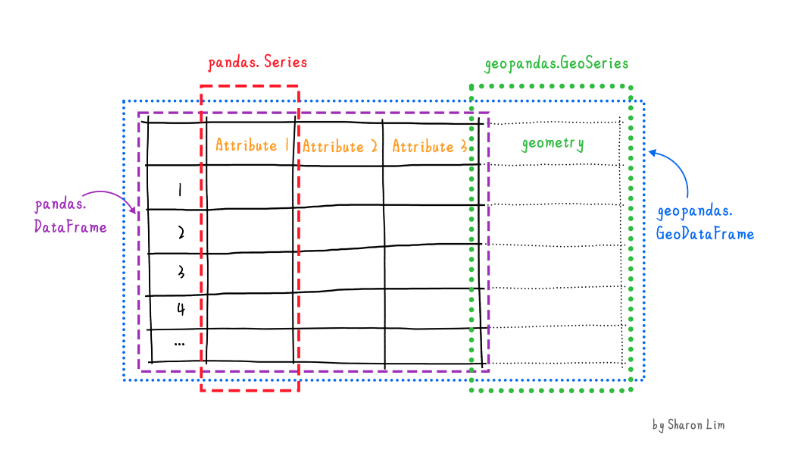

In this example, we will explore 2 datasets, `swfynbos.gpkg`, a dataset of the vegetation types of the southwestern Cape of South Africa, and `fynbos_remnants`, a dataset of the remaining fragments of natural vegetation in this region. This data is in the geopackage format but Geopandas can open all commonly encountered geospatial vector data formats.

In [ ]:
#we typically use the alias gpd
import geopandas as gpd

#read file
vegtypes = gpd.read_file('data/swfynbos.gpkg')

#view some rows
vegtypes.head()

Before getting into some data manipulations, lets looks at some attributes of the data. Geopandas allows us to easlity access some relevant attributes of our data

In [ ]:
#the type of each geometry
print(vegtypes.type)

In [ ]:
#area of each polygon
print(vegtypes.area)

In [ ]:
#centroid of each polygon
print(vegtypes.centroid)

We can print the coordinate reference system of the geodataframe using `.crs`

In [ ]:
vegtypes.crs

Doing things like filters, selecting columns and rows, etc works exactly like a Pandas dataframe, as a geodataframe is a subclass of a dataframe

In [ ]:
#select first 5 rows
print(vegtypes.iloc[0:5])

In [ ]:
#filter to a single vegtypes
print(vegtypes.query('Name_18 == "Hangklip Sand Fynbos"').head())


Plotting is easy too. Like Pandas there is a handy `.plot()` method for geodataframes. If we give it a column name as the first argument, it will color the plot by that column.

In [ ]:
#colour plot by vegetation type
vegtypes.plot('Name_18')

## 1.1 - Geometric manipulations and joins

Before we start playing with maniplating geodataframes based on their geometries, let's load another dataset that we will combine with the first

In [ ]:
remnants = gpd.read_file('data/remnants.gpkg')
#lets view the first few rows
remnants.head()

Set operations like intersections and unions can be applied using the `gpd.overlay()` function. Let's extract the remaining natural vegetation of each vegetation type

In [ ]:
#intersection of vegtypes and remnants
veg_remnants = gpd.overlay(vegtypes,remnants,how='intersection')

#plot!
veg_remnants.plot('Name_18')

When executing set operations, the properties from both input dataframes are retained, so each row in the output will have all the columns from the inputs

In [ ]:
veg_remnants.head()

finally, lets combine all polygons with the same threat status together using `dissolve` to simplify our geodataframe

In [ ]:
#all polygons with the saem threat status into one
veg_remnants_simple = veg_remnants.dissolve('RLE2021')
#view
veg_remnants_simple.head()

There is tons more functionality in GeoPandas, you can spatially join geodatframes with `.sjoin()`, reproject using `to_crs()`, and do all the good stuff you would expect. Two great places to dive deeper are the [GeoPandas user guide](https://geopandas.org/en/stable/docs/user_guide.html), and [the Carpentries lesson on vector data in Python](https://carpentries-incubator.github.io/geospatial-python/07-vector-data-in-python/index.html)

# 2. Gridded data with Xarray

## 2.0 - Xarray basics

[Xarray](https://docs.xarray.dev/en/stable/) is the meat and potatoes of working with multidimensional gridded data in Python. While numpy provides many of the core operations we need for working with gridded data like indexing  matrix operations, etc it does not provide the functionality to add information about the various dimensions of arrays, the coordinates of grid cells, or attached important metadata. This is where Xarray comes in.

By including labels on array dimensions Xarray opens up many new possibilities:

- applying operations over dimensions by name: x.sum('time').

- selecting values by label x.sel(time='2014-01-01').

- use the split-apply-combine paradigm with groupby: x.groupby('time.dayofyear').mean().

- keeping track of arbitrary metadata in the form of a Python dictionary: x.attrs.

- and much more

The Xarray data structure makes it trivial to go from 2 to 3 to 4 to N dimensions, hence it is a great choice for working with imaging spectroscopy data where we will have at least 3 (lat, lon, wavelength) dimensions. Another big benefit is that it seamlessly integrates with `Dask` a popular library for parallel computing in Python. This allows us to scale analysis with Xarray to very large data.



The core data structure of Xarray is an `xarray.DataArray` - which in its simplest form is just a Numpy array with named dimensions and coordinates on those dimensions. We can combine multiple `xarray.DataArray` in a single structure called a `xarray.Dataset`. Let's see what this looks like

In [ ]:
#typically we use the xr aliais
import xarray as xr
import numpy as np

#create a 2x3 np array
arr = np.random.randn(2, 3)

#create a xarray.DataArray by naming the dims and giving them coordinates
xda = xr.DataArray(arr,
                    dims=("x", "y"),
                    coords={"x": [10, 20],
                            "y": [1.1,1.2,1.3]})

xda

We can access the individual components like the data itself, the dimension names or the coordinates using accessors

In [ ]:
#get the actual data
print(xda.values)

In [ ]:
#get teh dimenson names
print(xda.dims)

In [ ]:
#get the x coordinates
print(xda.x)

We can set or get any metadata attribute we like

In [ ]:
xda.attrs["long_name"] = "random mesurement"
xda.attrs["random_attribute"] = 123

print(xda.attrs)

and perform calculations on `xarray.DataArrays` as if they were Numpy arrays

In [ ]:
xda + 10

In [ ]:
np.sin(xda)

An `xarray.Dataset` is a container of multiple aligned DataArray objects

In [ ]:
#create a new dataarray with aligned dimensions (but it can be more or fewer dims)
#create a new 2x3x4 xarray Dataarray
arr2 = np.random.randn(2, 3,4)
xda2 = xr.DataArray(arr2,
                    dims=("x", "y","z"),
                    coords={"x": [10, 20],
                            "y": [1.1,1.2,1.3],
                            "z": [20,200,2000,20000]})

#combine with another xarray.DataArray to make a xarray.Dataset
xds = xr.Dataset({'foo':xda,'bar':xda2})
xds


Here you can see that we have multiple arrays in a single dataset. Xarray automatically aligns the arrays based on shared dimensions and coodrinates. You can do almost everything you can do with DataArray objects with Dataset objects (including indexing and arithmetic) if you prefer to work with multiple variables at once. You can also easily retrieve a single DataArray by name from a Dataset

In [ ]:
xds.foo
# xds['foo'] works the same

## 2.1 - Terminology
It is important to be precise with our terminology when dealing with Xarrays as things can quickly get confusing when working with many dims. The full glossary can be found [here](https://docs.xarray.dev/en/stable/user-guide/terminology.html), but a quick recap:
- `xarray.DataArray` - A multi-dimensional array with labeled or named dimensions
- `xarray.Dataset` - A collection of DataArrays with aligned dimensions
- **Dimension** - The (named) axes of an array
- **Coordinate** - An array that labels a dimension

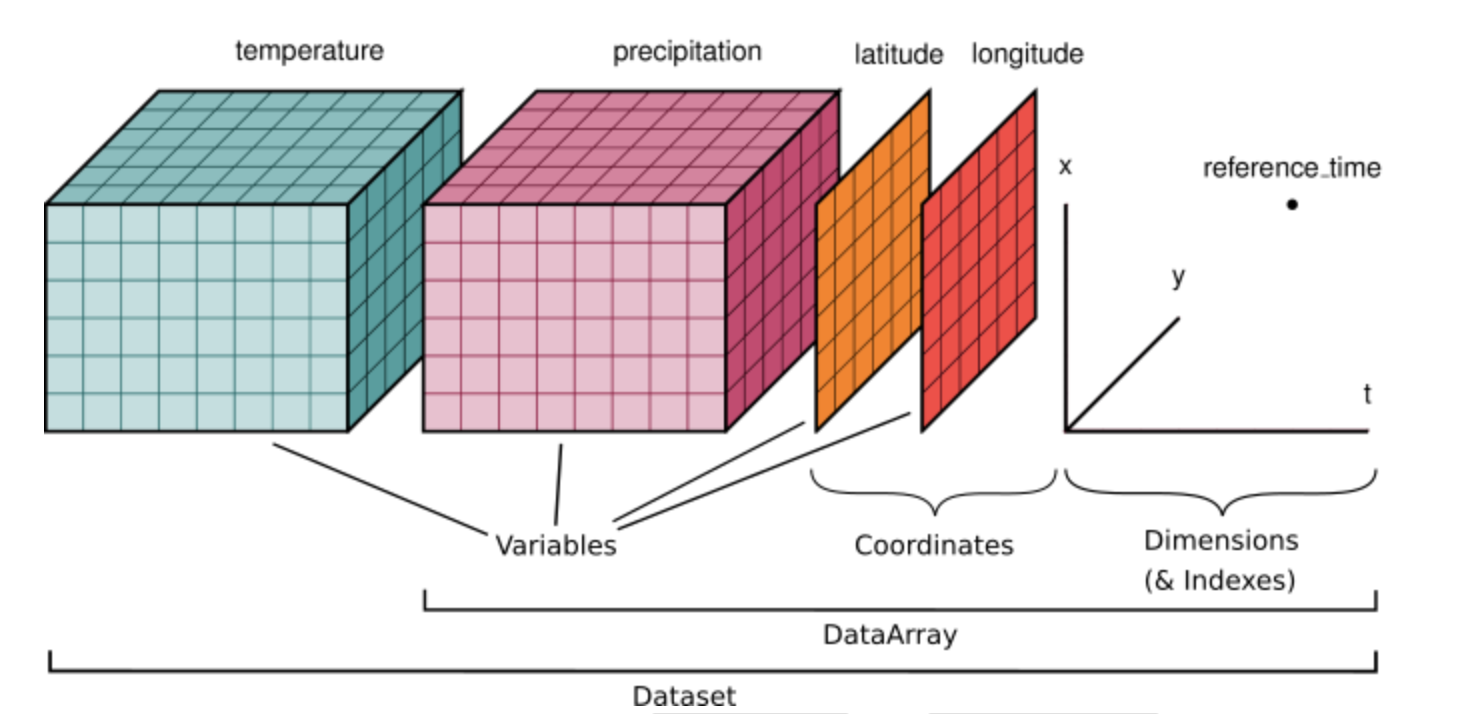

## 2.2 - loading data from files

Xarray supports reading and writing of several file formats, from simple Pickle files to the more flexible netCDF format. The recommended way to store Xarray data structures is netCDF. Xarray is based on the netCDF data model, so netCDF files on disk directly correspond to Dataset objects. If you aren’t familiar with this data format, the [netCDF FAQ](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#What-Is-netCDF) is a good place to start. When we are working with complex multidimensional data, file formats start to matter a lot, and they make a big difference to how fast and efficiently we can load and analyse data. More on this in the next lesson.

We can load netCDF files to create a new Dataset using `open_dataset()`. Similarly, a DataArray can be saved to disk using the `DataArray.to_netcdf()` method

For the rest of this lesson we will work with a small dataset from a [Specim FENIX](https://www.specim.com/products/fenix/) airbone imaging spectrometer collected near the town of Franschoek, near Cape Town in 2018. Lots of important metadata about the image has been removed to keep this simple. All that remains are the measured reflectances, and the latitude, longitude and wavelength coordinates.

In [ ]:
xda_is = xr.open_dataset("data/is_example.nc")
xda_is

## 2.3 - indexing, selecting and masking

While you can use numpy-like indexing e.g `da[:,:]`, this does not make use of the power of having named dims and coords. Xarray as specific method for selecting using the position in the array `.isel()` and using the coordinates with `.sel()`

In [ ]:
#idexing using position
xda_is.isel(x=20,y=20)

We can extract a continous slice of an array dimension using `slice()`

In [ ]:
xda_is.isel(x=20,y=20,wl=slice(0,20))

and provide a vector of indeces if we like

In [ ]:
#a list with the positions we want
xind = [20,25,31]
#select
xda_is.isel(x=xind,y=20)

We can use all the same techniques, but provive coordinate values rather than positions if we use `.sel()`. We can also provide an option for what to do if we do not get an exact match to the provided coordinates.

In [ ]:
xda_is.sel(x=3.175e+05,y=6.263e+06,method='nearest')

We can mask values in our array using conditions based on the array values or coordinate values with `.where()`

In [ ]:
# drop bad bands
xda_is = xda_is.where(xda_is.wl < 2.1,drop=True)
xda_is

## 2.4 - grouping and aggregation

The split-apply-combine approach of group-by + apply operations can be applied neatly using coordinates as grouping variables, or values with another `xarray.DataArray`. A simple application of this in imaging spectroscopy might be spectral resampling. Here we will group into 0.1µm or 100nm bins and calculate the mean reflectance per bin

In [ ]:
#first create a vector of the bins
bins = np.arange(xda_is.wl.min(),xda_is.wl.max(),0.1)

In [ ]:
bins

In [ ]:
#groupby bin, then apply mean
xda_bin = xda_is.groupby_bins("wl", bins).mean()
xda_bin

You may notice that often it takes almost no time at all to run xarray code. This is because for many functions xarray does not load data from disk and actually perform the calculation, rather it simply prints a summary and high-level overview of the data that will be produced. This is called **Lazy computation** and is the smart thing to do when working with large datasets. Only when you really need to do the calculation does it actually happen - like when calling `.plot()` or writing results. We can force computation by running `xarray.DataArray.compute()`

In [ ]:
xda_bin.compute()

## 2.5 - plotting

Xarray is great for plotting. The simplest way to make a plot is to juse the `.plot()` method, much we like have deon with Pandas and GeoPandas. This will use matplotlib to create a plot for us. The type of plot will be determined from the number of dimensions in the Xarray.

In [ ]:
#plot a single pixel

#select the pixel we want
pixel = xda_is.sel(x=3.175e+05,y=6.2625e+06,method='nearest')

#make a scatter plot
pixel.reflectance.plot.scatter()

If we want to make a RGB plot, we can get back an image using `plot.imshow()`. This will automatically map the first 3 channels of the 3rd dim to Red Green Blue.

In [ ]:
#specify the wavelength of the RGB bands
rgb=[0.66,0.56,0.48]

In [ ]:
#select the RGB bands
rgbplot = xda_is.sel(wl=rgb,method='nearest')/10000
#plot!
rgbplot.reflectance.plot.imshow()

The abilities of the built-in `.plot()` method are somewhat limited. If you want to make beautiful, customized and interactive plots [Holoviews and hvplot](https://hvplot.holoviz.org/index.html) are the place to start. By importing holoview and hvplot, the `.plot()` method is replaced with `.hvplot()` and you plots instantly become way cooler.

In [ ]:
import holoviews as hv
import hvplot.xarray


Lets make the same plot iof an individual pixel as we did before, but this time lets make it interactive by using hvplot

In [ ]:
pixel.hvplot.scatter(y='reflectance',x='wl', color='black', frame_width=400)

We can replicate the rgb plot created using `plot.imshow()` with the `hvplot.rgb()` function

In [ ]:
rgbplot.reflectance.hvplot.rgb(x='x', y='y', bands='wl', aspect = 'equal', frame_width=400)

but the real magic happens when we start to customise the interactivity of our plots. With hvplot, it is relatvly straightforward to add thing like sliders and selectors. For example appling a groupby along a particular dimension allows us to explore the data as images along that dimension with a slider. 

This provide a neat way for us to explore different wavelengths

In [ ]:
xda_is.reflectance.hvplot(x='x', y='y', groupby='wl', aspect = 'equal', frame_width=400, cmap = 'nipy_spectral',clim=(0,6000))

If you know what you are doing, you can build some pretty stunning visualization and enable rich exploration of data. Panel is a Python library built on top of holoviews that lets you easily build powerful tools, dashboards and complex applications entirely in Python. I recommend this [Youtube video](https://www.youtube.com/watch?v=2zNniXTOBSU) to get a sense of the amazing things that are possible with Geospatial data using these tools. Some examples [here](https://panel-gallery.pyviz.demo.anaconda.com/vtk_interactive) and [here](https://panel-gallery.pyviz.demo.anaconda.com/glaciers).

# 3. Scaling computation with Dask

## 3.0 - What is dask

Xarray integrates with [Dask](https://www.dask.org/) to support parallel computations and streaming computation on datasets that don’t fit into memory. Currently, Dask is an entirely optional feature for Xarray. So you don't need to use it if your data fit comfortably in memory and do not take an excessive amount of time to analyse. Dask is widely used to parallelize and scale workflows in Python, and is probably the most widely used package for this purpose. It is not just useful for working with Xarray, but rather builds on top of Python packages like Numpy and Pandas, and even more fundamental Python data structures.

Dask builds on top of Numpy by cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. This type of object - a chunked Numpy array - is called a `dask.array`



In [ ]:
import dask.array as da
import numpy as np

#create a big np array
data = np.arange(100_000).reshape(200, 500)

#turn it into a dask.array by chopping it into chunks
darr1 = da.from_array(data, chunks=(100, 100))
darr1

Now we have a 2D array with the shape (200, 500) composed of 10 chunks where each chunk has the shape (100, 100). Each chunk represents a piece of the data, and is just a normal `np.array`  

We can execute most numpy functions on dask arrays. The difference is that they will not return the result, but rather just a reference to the yet-to-be initiated computation.

In [ ]:
darr1.mean()

Remember, to actual compute the results we need to call `.compute()`. This will return the result as a numpy array or list. 

In [ ]:
darr1.mean().compute()

We can force computation but keep the result in a chunked dask array by calling `.persist()`. This wont make much difference here, but we will see why this matters later.

We can chain operation together to create a more complex operation


In [ ]:
darr2 = da.from_array(data*10, chunks=(100, 100))
darr3 = darr1 + darr2
darr4 = darr3.mean()

As we do this dask build a graph of all the computational steps that need to be performed to compute the desired results. When we call `.compute()` the graph is executed. We can visualize this graph

In [ ]:
darr4.visualize(engine="cytoscape")

For most analyses that we may encounter this graph will probably be very complex and can be challenging to interpret.

## 3.1 -  But how does this parallelize work and allow us to scale to very large datasets you ask?

Well, by splitting our array up into a collection of smaller chunks, and building a graph of operations to perform on these chunks we have split what might have originally been a single operation too large for our machine into many smaller operations. We can now pick as many of these operations as we like at a time to perform in parallel. We can also optimize the size of each chunk such that we get the right balance between one large chunk too big to fit in memory and many millions of chunks that would result in unmanageably large graphs.

The final piece of the puzzle is managing the workers that execute the units of work we have created, this is done by the Scheduler. Dask provides a few options to do this. The simplest way is the default and it happens in the background when you do a computation on a dask array on a single machine automatically.

The details of how this works are beyond the scope here, but here is how I think about it (I am probably wrong):  
  
The scheduler creates a 'pool' of threads or processes to which it can allocate work (often n workers = n cores). A  thread/process pool in Python is like a team of workers. You specify how many workers are on the team. You give the team a list of tasks. Each worker is assigned a task from the list and does it. If all workers are busy, the remaining tasks wait. When a worker finishes a task, it picks up a new one from the list. This way, tasks are done concurrently, but the number of workers doing the tasks doesn't exceed the limit you set.

>Threads and Processes are not the same thing, and understanding the difference is very important if you want to properly understand parallel processing in Python. This is a complicated topic so I will not get into it here, but [here](https://blog.floydhub.com/multiprocessing-vs-threading-in-python-what-every-data-scientist-needs-to-know/) is a good place to start. ChatGPT will also do a good job of explaining some of the concepts here.

The scheduler keeps track of all the tasks completed, running, and queued. It knows which tasks depend on which data, what data is available, and what data is waiting on what tasks to complete before it can be released.

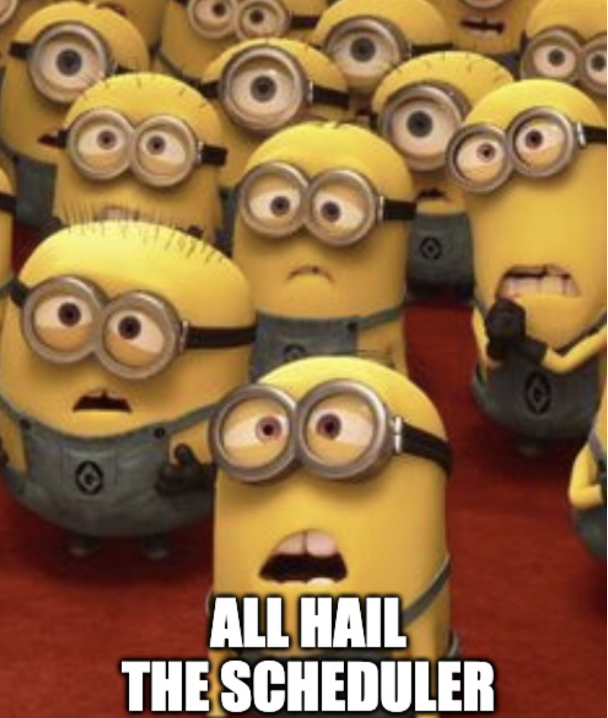

Now you have enough info to understand the image below which provides an overview of how dask works:

Operations on **Collections** created a **Task Graph**. A task graph is then executed by a scheduler. We have seen the `dask.array` collection, but there are others like `dask.dataframe`. We have already worked with the default single-machine scheduler, but to scale to large datasets we need to use the Distributed Scheduler.

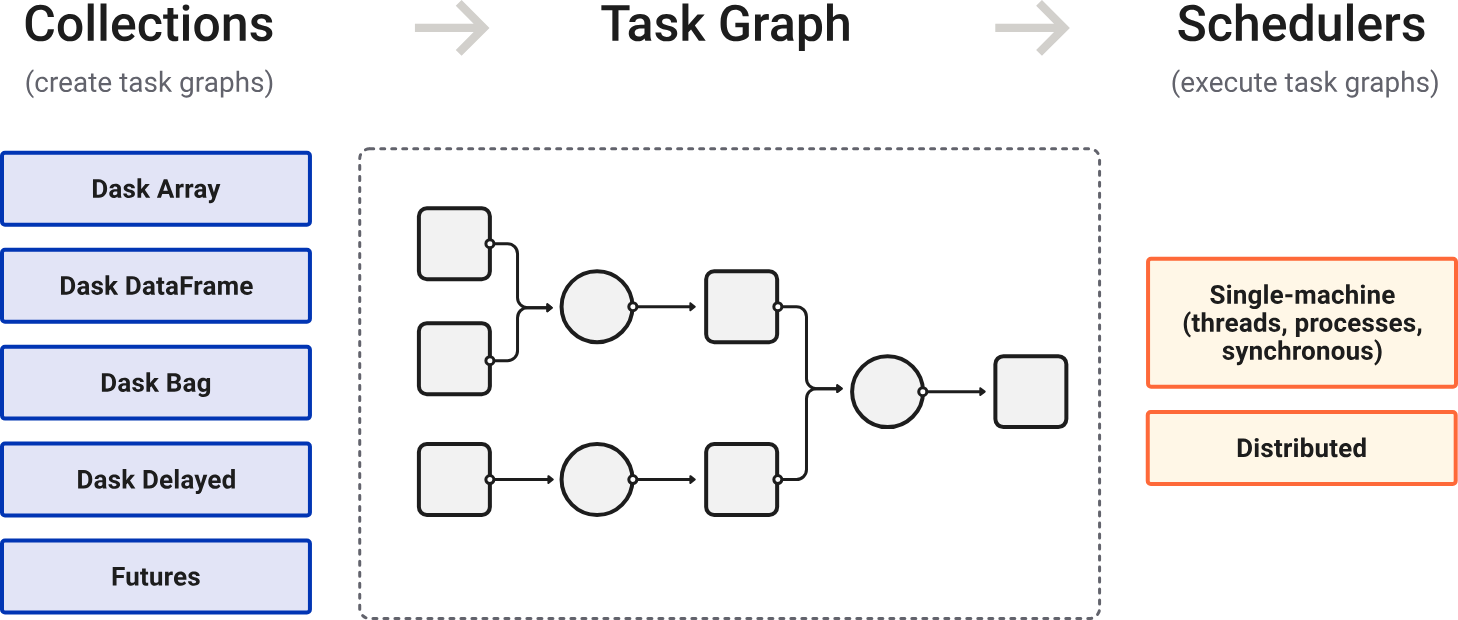

## 3.2 - Dask.distributed

The distributed scheduler is more sophisticated, offers more features, and can run locally or distributed across a cluster. The downside is that to setup a distributed cluster with multiple worker machines takes a bit of work. Fortunately, we can run the distributed scheduler on a single without much setup, and we get a bunch of extra features that we don't get with the default dask scheduler. However, for smaller data, the distributed scheduler will actually be much slower than the default scheduler or not using Dask at all. You should only use distributed when your data is much larger than what your computer can handle in memory.

If you want to find out about setting up a distributed schedular across a cluster you can read more [here](https://docs.dask.org/en/latest/deploying.html). [Coiled](https://www.coiled.io/) is a great service that simplifies setting up a dask cluster across multiple cloud machines. With Coiled and Dask, you can quickly and easily get setup to analyse massive (Petabyte scale) datasets.

For the rest of this exercise we will use the distributed scheduler on a local machine, but all the features demoed will work the same if you use a cluster.

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4)  # Launches a distributed scheduler and workers locally
client = Client(cluster)  # Connect to distributed scheduler and override default
client

click on the dashboard link. It will open a tab but there won't be much there yet.
Let's execute the computational graph we created earlier. 
Let's make it a bit bigger so that we actually have some work to do

In [ ]:
data = np.arange(20000000).reshape(2000, 10000)
darr1 = da.from_array(data, chunks=(100, 100))
darr2 = da.from_array(data*10, chunks=(100, 100))
darr3 = darr1 + darr2
darr4 = darr3.mean()

In [ ]:
darr4.compute()

Now go to the dashboard.
There are numerous diagnostic plots available on the landing page.

 - __Bytes Stored and Bytes per Worker__:  
 These two plots show a summary of the overall memory usage on the cluster (Bytes Stored), as well as the individual usage on each worker (Bytes per Worker).
 
 - __Task Processing/CPU Utilization/Occupancy/Data Transfer__:  
  The Processing tab in the figure shows the number of tasks that have been assigned to each worker. Not all of these tasks are necessarily executing at the moment: a worker only executes as many tasks at once as it has threads.
- __Progress__: The progress bars plot shows the progress of each individual task type. The color of each bar matches the color of the individual tasks on the task stream from the same task type

 - __Task Stream__: The task stream is a view of which tasks have been running on each thread of each worker. It allows us to see not only the current activity but the past too. Each row represents a thread, and each rectangle represents an individual task. The color for each rectangle corresponds to the task type of the task being performed and matches the color of the Progress plot.  

  In some scenarios, the dashboard will have white spaces between each rectangle. During that time, the worker thread was idle. Having too much white space is an indication of sub-optimal use of resources. Additionally, a lot of long red bars (transfers) can indicate a performance problem, due to anything from too large of chunk sizes, too complex of a graph, or even poor scheduling choices.
  The task stream is the quickest way to diagnose if your computation has any issues. The example below shows you what the task stream for a healthy and unhealthy computation might look like


An example of a healthy Task Stream, with little to no white space.

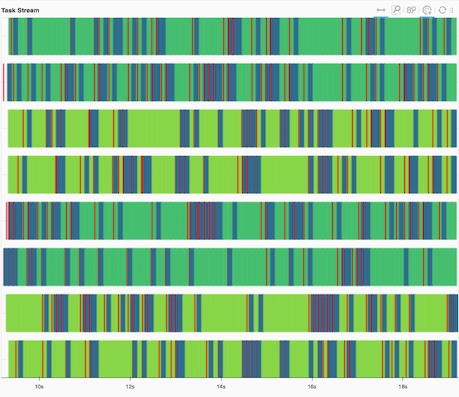

An example of an unhealthy Task Stream, with a lot of white space. Workers were idle most of the time. Additionally, there are some long transfers (red) which don’t overlap with computation.

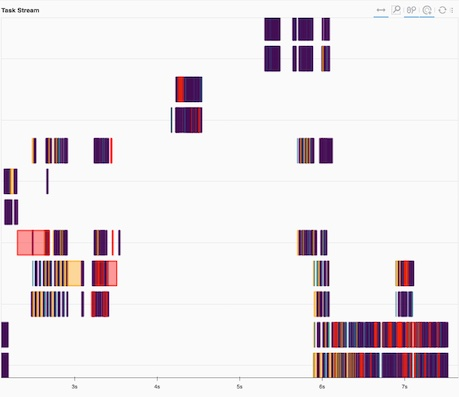

This was just a quick tour, the dask dashboard is very powerful and the first place to look when you want to understand how your computation is progressing. Read more about it [here](https://docs.dask.org/en/stable/dashboard.html) or watch this great [Youtube video](https://youtu.be/N_GqzcuGLCY) by dask creator Matthew Rocklin

## *Chunking is important*

The chunks parameter has critical performance implications when using Dask arrays. If your chunks are too small, queueing up operations will be extremely slow, because Dask will translate each operation into a huge number of operations mapped across chunks. Computation on Dask arrays with small chunks can also be slow, because each operation on a chunk has some fixed overhead from the Python interpreter and the Dask task executor.

Conversely, if your chunks are too big, some of your computation may be wasted if you don't have workers but not enough chunks to keep them busy. You may also run out of memory with big chunks.

A good rule of thumb is to create arrays with a minimum chunksize of at least one million elements (e.g., a 1000x1000 matrix). With large arrays (10+ GB), the cost of queueing up Dask operations can be noticeable, and you may need even larger chunksizes.

Checkout the [dask documentation on chunks](https://docs.dask.org/en/latest/array-chunks.html) to find out more about what to consider when deciding how to chunk your array.

# 3.3 - Xarray and dask

Now let's spinlkle some of that tasty dask spice onto our xarrays


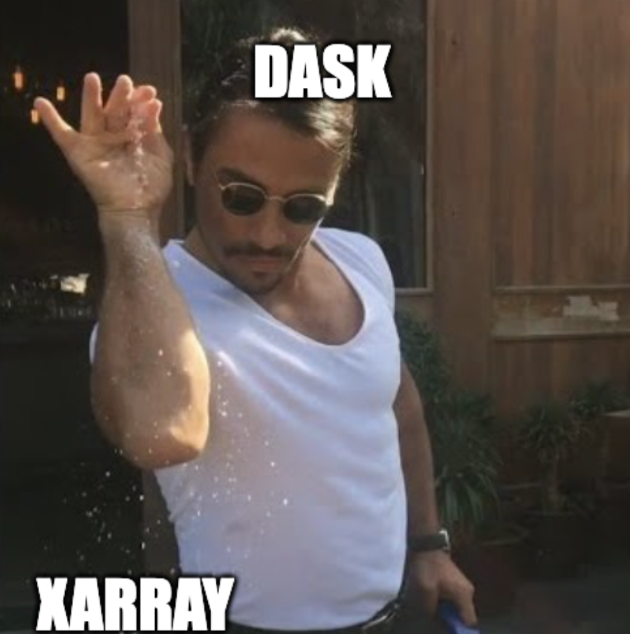


xarray is built to natively work with dask arrays. The data in your xarray can be either a np.array or a dask.array. Almost all xarray functions work on both.

To convert an xarray with data in a numpy array to a dask array you just need to specify the chunking using `.chunk`. You can also load data directy into a dask array by including the `chunks` argument when using `xr.open_dataset`.

In [ ]:
xda_chunk = xr.open_dataset("data/is_example.nc",chunks={'x':50,'y':50,'wl':-1})
xda_chunk

### _I'll say it again. Chunking matters_
Above I specified that we would split that data into chunks along the x and y dims and not along the wavelength dim. This means that when I perform an operation, the algorithm will only see a subset of the full spatial domain at once, but all of the bands. If we expect that our analysis will mostly involve calculation that considers each pixel independently, but will need all the bands (like spectral resampling) this makes sense. However, we might want to chunk differently if our plan was to calculate neighbourhood statistics on each band independently as we might then need to see a large spatial subset of the data at once.

The point of this is: you need to think about how you plan to analyse the data to determine how to chunk it

#### Default chunking and rechunking
Some file types like netCDF or zarr have native chunking, and it is usually most efficient to use the chunking that is already present. If you specify `chunks='auto'` chunking will be automatically determined. This is a major advantage as chunking/rechunking can be expensive for large files. The downside is that you are subject to the chunking chosen by the creator of the file. 

You always have the option of changing the chunking by just applying `.chunk()` again later in your workflow. This can make sense if you are about to use algorithm for which a different chunking scheme is appropriate. But beware of doing this unnecessarily.


Lets try our spectral resampling again, this time using a chunked array

In [ ]:
xda_bin = xda_chunk.groupby_bins("wl", bins).mean()

Remember, nothing will happen until will call `.compute()`

In [ ]:
xda_bin.compute()

You can see that forcing computation using `compute()` returned a Numpy array. If we want to force computation but keep the resulting array as a chunked Dask array we can use `persist()` instead.

In [ ]:
xda_bin.persist()

## 3.4 - Automatic parallelization with `apply_ufunc()`


Almost all of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by xarray, use `apply_ufunc()` to apply functions that consume and return Numpy arrays. `apply_ufunc()` will apply an embarrassingly parallel custom function to each chunk. The function will receive each chunk as a `np.array` and should return a `np.array`. 

Let's look at a simple example. Normalisation is a common transformation applied to spectra to remove the influence of the absolute magnitude of reflectance and ensure that only the shape of spectra is relevant for subsequent analyses. After applying normalization all bands/wavelengths should sum to 1. 

Here is a function to normalise a `np.array`



In [ ]:
def norm_wl(arr: np.array):
    # Calculate the magnitude along the wavelength dimension
    magnitude = np.sum(arr, axis=0, keepdims=True)
    # Normalize the array along the wavelength dimension
    normalized_array = arr / magnitude
    return normalized_array


`apply_ufunc()` take the function we are mapping as it's first arguemnt, then the xarray

In [ ]:
xda_norm = xr.apply_ufunc(
    norm_wl,
    xda_chunk['reflectance'],
    dask = "parallelized",
    output_dtypes=[int])

xda_norm.persist()

# 4. Make it Geospatial

## 4.0 - rioxarray

Although we have latitude and longitude values associated with our Xarray, this data is not a proper geospatial dataset and hence we cannot do spatial manipulations like calculating distances or reprojecting. Xarray is a general-purpose tool for any multidimensional data and is not specific to geospatial data. We need an additional package `rioxarray` which brings all of the power of `GDAL` to Xarrays. `rioxarray` extends Xarray with the `rio` accessor. What this means is that a bunch of new functions become available to Xarray instances by typing `xarray.DataArray.rio.` 

In [ ]:
import rioxarray

The first and most important detail we need to add before turning our Xarray into a geospatial dataset is information about the projection. Here we know the current crs is epsg:32734 (UTM zone 34S) 

In [ ]:
xda_chunk = xda_chunk.rio.write_crs('epsg:32734')
xda_chunk.rio.crs

In [ ]:
xda_chunk

Now that we know the current projection, it is easy to reproject to match the projection of the vector data we were working with earlier

In [ ]:
xda_chunk_wgs = xda_chunk.rio.reproject('epsg:4326')
xda_chunk_wgs

Now that we are in the same projection as our vector data, let's clip our raster to the vector data and extract only the intact natural vegetation of the vegetation type we are interested in

In [ ]:
#we need to do this first to deal with bad geometries in the vector data
vclip = veg_remnants_simple.buffer(0)

#clip
xda_clip = xda_chunk_wgs.rio.clip(vclip)

We can repeat the plot we did earlier, but now only plotting data for intact natural vegetation

In [ ]:
xda_clip.hvplot(x='x', y='y', groupby='wl', aspect = 'equal', frame_width=400,clim=(0, 5000),cmap='nipy_spectral')

rioxarray gives us the ability to read and write any file format supported by GDAL. This is as simple as `rioxarray.open_rasterio()` and `xarray.DataArray.rio.to_raster()`

## credits:

This lesson has borrowed heavily from:    

[The Carpentries Geospatial Python lesson by Ryan Avery](https://carpentries-incubator.github.io/geospatial-python/)  

[The geopandas user guide](https://geopandas.org/en/stable/docs/user_guide.html)  

[The xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)  
  
[The Dask tutorial from SciPy202](https://tutorial.dask.org/index.html)  

[An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html)
